## Import Libraries

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import zipfile
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn import metrics
from skimage import exposure
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential, Model

import helper_functions as hlp
import function_model_definition as md

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [2]:
# tf.config.experimental.get_memory_usage("GPU:0")

## Load Data 


In [3]:
# Define the path + output path:
print(os.getcwd())
DIR = "/tf/notebooks/"
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
# IMG_DIR2 = "/tf/notebooks/kook/data-sets/stroke-lh/"
DATA_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/weights/"


/tf/notebooks/brdd/xAI_3d


In [4]:
# model_name = "3d_cnn_binary_model_split6_unnormalized_flatten_layer_paper_model_{epoch:03d}.h5"
model_name = "3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_10.h5"
train= True

layer_connection = "globalAveragePooling"
last_activation = "sigmoid"

In [5]:
with h5py.File(IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', "r") as h5:
# with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]
    
X_in = np.expand_dims(X_in, axis = 4)
print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())


(439, 128, 128, 28, 1) -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0


In [6]:
# def normalize(volume):
#     """Normalize the volume"""
#     min = np.min(volume)
#     max = np.max(volume) 
#     volume = (volume - min) / (max - min)
#     volume = volume.astype("float32")
#     return volume

# X_in = np.array([normalize(img) for img in X_in])
# print(X_in.shape, X_in.min(), X_in.max(), X_in.mean(), X_in.std())

In [7]:
# dat = pd.read_csv('/tf/notebooks/avci/xAI_3D/data/baseline_data_zurich_prepared0.csv', sep=";")
dat = pd.read_csv(IMG_DIR + 'baseline_data_zurich_prepared.csv', sep=",")

In [8]:
dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia
0,101,1,1.196256,-1.295848,0.645662,3.057795,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,-1.237729,-0.556297,-0.460976,2.107803,0
1,103,0,-2.512593,-1.295848,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,-0.448358,-1.237729,-0.556297,-0.460976,-0.473492,0
2,104,0,1.025281,0.770174,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,2.225964,0.806338,-0.556297,-0.460976,-0.473492,0
3,105,6,1.432992,-1.295848,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,0.806338,-0.556297,-0.460976,-0.473492,0
4,106,0,-0.539801,-1.295848,-0.820817,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,-0.448358,-1.237729,-0.556297,-0.460976,-0.473492,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,536,0,-1.473589,0.770174,-0.657875,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,0.806338,1.794057,-0.460976,-0.473492,1
503,540,2,0.828002,-1.295848,0.319778,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,-0.448358,0.806338,-0.556297,-0.460976,-0.473492,1
504,541,0,-3.183342,0.770174,0.808604,-0.470965,-0.419507,-0.263596,-0.118205,-1.400370,-0.448358,-1.237729,-0.556297,-0.460976,-0.473492,1
505,542,1,0.038885,0.770174,-0.331991,-0.470965,-0.419507,-0.263596,-0.118205,0.712688,2.225964,-1.237729,-0.556297,-0.460976,-0.473492,1


In [9]:
andrea_splits = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/andrea_splits.csv', 
                            sep='\,', header = None, engine = 'python', 
                            usecols = [1,2,3]).apply(lambda x: x.str.replace(r"\"",""))
andrea_splits.columns = andrea_splits.iloc[0]
andrea_splits.drop(index=0, inplace=True)
andrea_splits = andrea_splits.astype({'idx': 'int32', 'spl': 'int32'})

In [10]:
split6 = andrea_splits.loc[andrea_splits['spl']==6]

In [11]:
split6

,idx,type,spl
2036,372,test,6
2037,284,test,6
2038,298,test,6
2039,203,test,6
2040,292,test,6
...,...,...,...
2438,403,train,6
2439,404,train,6
2440,405,train,6
2441,406,train,6


In [12]:
dat.p_id.max()

563

In [13]:
n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], X_in.shape[4]))
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id[i] = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
X_tab.shape

(407, 13)

In [14]:
np.mean(Y_pat)

0.7038724373576309

In [15]:
for i in range(7):
    print(np.mean(Y_mrs == i))
    
# n0 = 184 (45.2%), 
# n1 = 88 (21.6%), 
# n2 = 60 (14.7%), 
# n3 = 25 (6.1%),
# n4 = 20 (4.9%), 
# n5 = 5 (1.2%), 
# n6 = 25 (6.1%)

# mRS 0-2 (80.9%) vs. mRS 3-6 (18.3%)

0.4520884520884521
0.21621621621621623
0.14742014742014742
0.06142506142506143
0.04914004914004914
0.012285012285012284
0.06142506142506143


In [16]:
np.mean(Y_eventtia)

0.7248157248157249

In [17]:
# # Split data into training set and test set "old"

# X = np.squeeze(X)
# X = np.float32(X)

# rng = check_random_state(42)
# X_train, X_test, y_train, y_test = train_test_split(X, Y_eventtia, train_size=0.8, random_state=rng)
# X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=rng)

# print(X_train.shape, X_valid.shape, X_test.shape)
# print(y_train.shape, y_valid.shape, y_test.shape)

In [18]:
Y_new = []
for element in Y_mrs:
    if element in [0,1,2]:
        Y_new.append(0)
    else:
        Y_new.append(1)
Y_new = np.array(Y_new)

In [19]:
np.mean(Y_new)

0.18427518427518427

In [20]:
# Split data into training set and test set "split6"

X = np.squeeze(X)
X = np.float32(X)

train_idx = split6["idx"][split6['type'] == "train"].to_numpy() -1 
valid_idx = split6["idx"][split6['type'] == "val"].to_numpy() - 1 
test_idx = split6["idx"][split6['type'] == "test"].to_numpy() - 1 

X_train = X[train_idx]
# y_train = Y_eventtia[train_idx]
y_train = Y_new[train_idx]
X_valid = X[valid_idx]
# y_valid = Y_eventtia[valid_idx]
y_valid = Y_new[valid_idx]
X_test = X[test_idx]
# y_test = Y_eventtia[test_idx]
y_test = Y_new[test_idx]

print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(325, 128, 128, 28) (41, 128, 128, 28) (41, 128, 128, 28)
(325,) (41,) (41,)


In [21]:
print(np.mean(y_train))
print(np.mean(y_valid))
print(np.mean(y_test))

0.19076923076923077
0.17073170731707318
0.14634146341463414


## 3D Data Augmentation

In [22]:
#augmentation functions

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, mode='nearest', reshape=False)
#         volume[volume < 0] = 0
#         volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


@tf.function
def zoom(volume):
    """Rotate the volume by a few degrees"""

    def random_zoom3d(X_im, min_zoom = 0.85 , max_zoom = 1.15):
        z = np.random.sample() *(max_zoom-min_zoom) + min_zoom
        zoom_matrix = np.array([[z, 0, 0, 0],
                            [0, z, 0, 0],
                            [0, 0, z, 0],
                            [0, 0, 0, 1]])
        volume = ndimage.affine_transform(X_im, zoom_matrix, mode = "nearest", order = 1)
        return volume

    augmented_volume = tf.numpy_function(random_zoom3d, [volume], tf.float32)
    return augmented_volume


@tf.function
def gauss(volume):
    """Add some noise and smooth it with a gaussian filter"""

    def random_gaussianfilter3d(X_im, sigma_max=0.2):
        sigma = np.random.uniform(0, sigma_max)
        volume = ndimage.gaussian_filter(X_im, sigma, mode = "nearest")
        return volume

    augmented_volume = tf.numpy_function(random_gaussianfilter3d, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = zoom(volume)
#     volume = gauss(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label



## Model

In [23]:
input_dim = np.expand_dims(X_train, axis = -1).shape[1:]
output_dim = 1

# call model
model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.summary()


Model: "cnn_3d_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 28, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 128, 128, 28, 32)  896       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 14, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 14, 32)    27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 32, 32, 7, 32)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 7, 64)     55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 3, 64)     0   

In [24]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

batch_size = 6

# Augment the on the fly during training.
# train_dataset = (
#     train_loader.shuffle(len(X_train))
#     .map(train_preprocessing)
#     .batch(batch_size)
#     .prefetch(2)
# )

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode="nearest")
datagen.fit(X_train)

validation_dataset = (
    validation_loader.shuffle(len(X_valid))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

#compile
model_3d.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# Define callbacks.
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     OUTPUT_DIR + model_name, 
#     save_best_only=True
# )
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    filepath = OUTPUT_DIR + "epochs/" + model_name,
    verbose = 1,
    save_weights_only = True,
    monitor = "val_loss", #'val_acc',
    mode = 'min',
    save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (325, 128, 128, 28) (28 channels).
  ' channels).')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (325, 128, 128, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


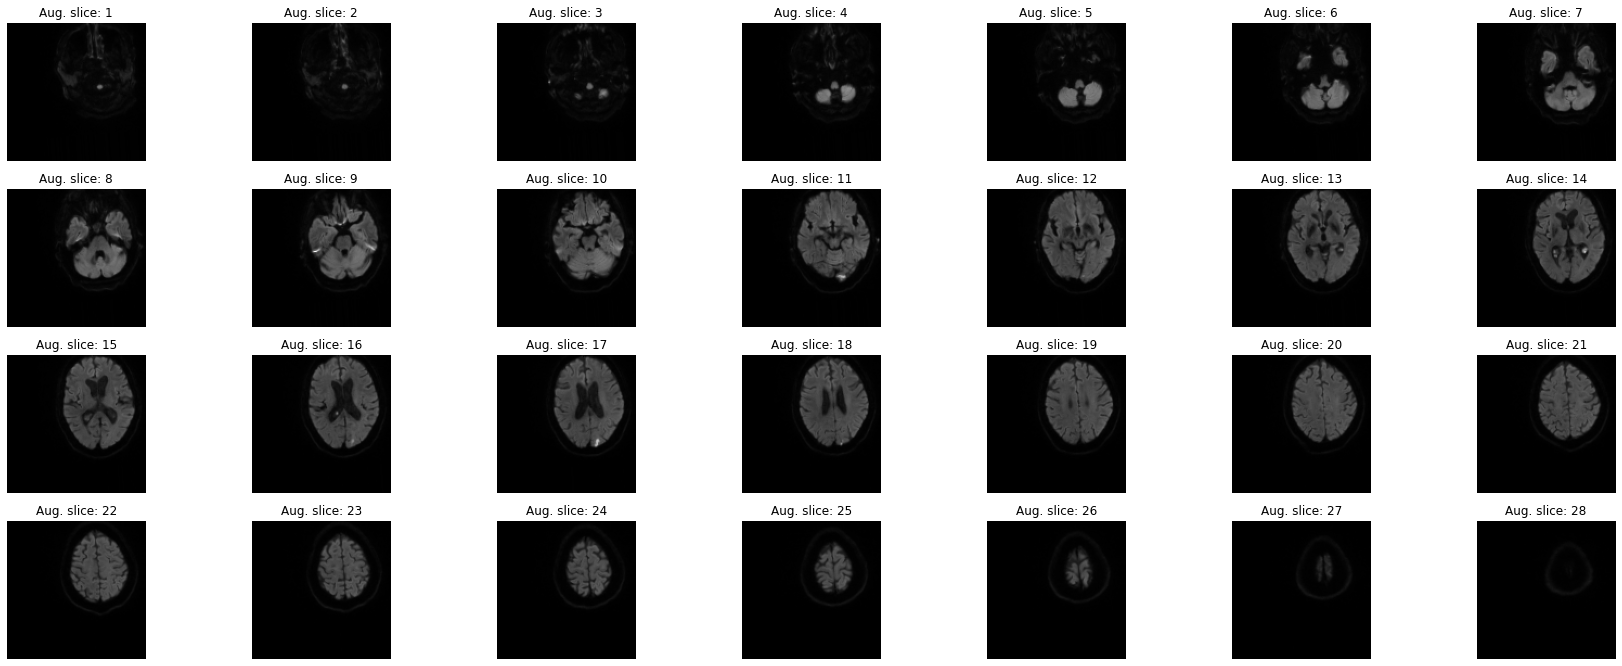

0

In [25]:
#Visualize Augemntation
# data = train_dataset.take(1)
# images, labels = list(data)[0]
# images = images.numpy()
data = datagen.flow(X_train, y_train, batch_size=batch_size)[0]
images, labels = data
image = images[0]

plt.figure(figsize=(30,30))
for i in range(image.shape[2]):
    plt.subplot(10,7,i+1)
    plt.imshow(np.squeeze(image[:, :, i]), cmap="gray", vmin = np.min(image), vmax = np.max(image))
#     plt.imshow(np.squeeze(image[:, i,: ]), cmap="gray")
    plt.axis('off')
    plt.title(str("Aug. slice: " + str(i+1)))
plt.show()

labels[0]

In [26]:
# Train the model, doing validation at the end of each epoch
epochs = 160

if train:
    hist = model_3d.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
        validation_data=validation_dataset,
        epochs=epochs,
        shuffle=True,
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb]
)  


Epoch 1/160
55/55 [==============================] - 30s 377ms/step - loss: 0.6404 - acc: 0.7239 - auc: 0.3915 - val_loss: 0.4662 - val_acc: 0.8293 - val_auc: 0.3130

Epoch 00001: val_loss improved from inf to 0.46617, saving model to /tf/notebooks/brdd/xAI_3d/weights/epochs/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_10.h5
Epoch 2/160
55/55 [==============================] - 7s 134ms/step - loss: 0.4766 - acc: 0.8365 - auc: 0.4186 - val_loss: 0.4638 - val_acc: 0.8293 - val_auc: 0.2920

Epoch 00002: val_loss improved from 0.46617 to 0.46381, saving model to /tf/notebooks/brdd/xAI_3d/weights/epochs/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_10.h5
Epoch 3/160
55/55 [==============================] - 7s 131ms/step - loss: 0.4592 - acc: 0.8361 - auc: 0.5100 - val_loss: 0.4633 - val_acc: 0.8293 - val_auc: 0.3382

Epoch 00003: val_loss improved from 0.46381 to 0.46332, saving model to /tf/notebooks/brdd/xAI_3d/weights

55/55 [==============================] - 7s 134ms/step - loss: 0.4805 - acc: 0.7877 - auc: 0.7066 - val_loss: 0.4699 - val_acc: 0.8293 - val_auc: 0.5315

Epoch 00064: val_loss did not improve from 0.45571
Epoch 65/160
55/55 [==============================] - 8s 137ms/step - loss: 0.5018 - acc: 0.8100 - auc: 0.5656 - val_loss: 0.4552 - val_acc: 0.8293 - val_auc: 0.5336

Epoch 00065: val_loss improved from 0.45571 to 0.45517, saving model to /tf/notebooks/brdd/xAI_3d/weights/epochs/3d_cnn_binary_model_split6_unnormalized_avg_layer_paper_model_sigmoid_activation_10.h5
Epoch 66/160
55/55 [==============================] - 8s 135ms/step - loss: 0.4658 - acc: 0.8142 - auc: 0.6058 - val_loss: 0.4579 - val_acc: 0.8293 - val_auc: 0.5399

Epoch 00066: val_loss did not improve from 0.45517
Epoch 67/160
55/55 [==============================] - 7s 133ms/step - loss: 0.4581 - acc: 0.8105 - auc: 0.6614 - val_loss: 0.4656 - val_acc: 0.8293 - val_auc: 0.5420

Epoch 00067: val_loss did not improve from 

55/55 [==============================] - 7s 130ms/step - loss: 0.3761 - acc: 0.8413 - auc: 0.8370 - val_loss: 0.4226 - val_acc: 0.8049 - val_auc: 0.7185

Epoch 00127: val_loss did not improve from 0.40311
Epoch 128/160
55/55 [==============================] - 7s 132ms/step - loss: 0.3431 - acc: 0.8746 - auc: 0.8433 - val_loss: 0.4155 - val_acc: 0.8293 - val_auc: 0.7206

Epoch 00128: val_loss did not improve from 0.40311
Epoch 129/160
55/55 [==============================] - 7s 133ms/step - loss: 0.3448 - acc: 0.8699 - auc: 0.8231 - val_loss: 0.4171 - val_acc: 0.8293 - val_auc: 0.7080

Epoch 00129: val_loss did not improve from 0.40311
Epoch 130/160
55/55 [==============================] - 7s 132ms/step - loss: 0.3951 - acc: 0.8639 - auc: 0.7805 - val_loss: 0.4181 - val_acc: 0.8049 - val_auc: 0.7206

Epoch 00130: val_loss did not improve from 0.40311
Epoch 131/160
55/55 [==============================] - 7s 132ms/step - loss: 0.3652 - acc: 0.8545 - auc: 0.7597 - val_loss: 0.4277 - val_a

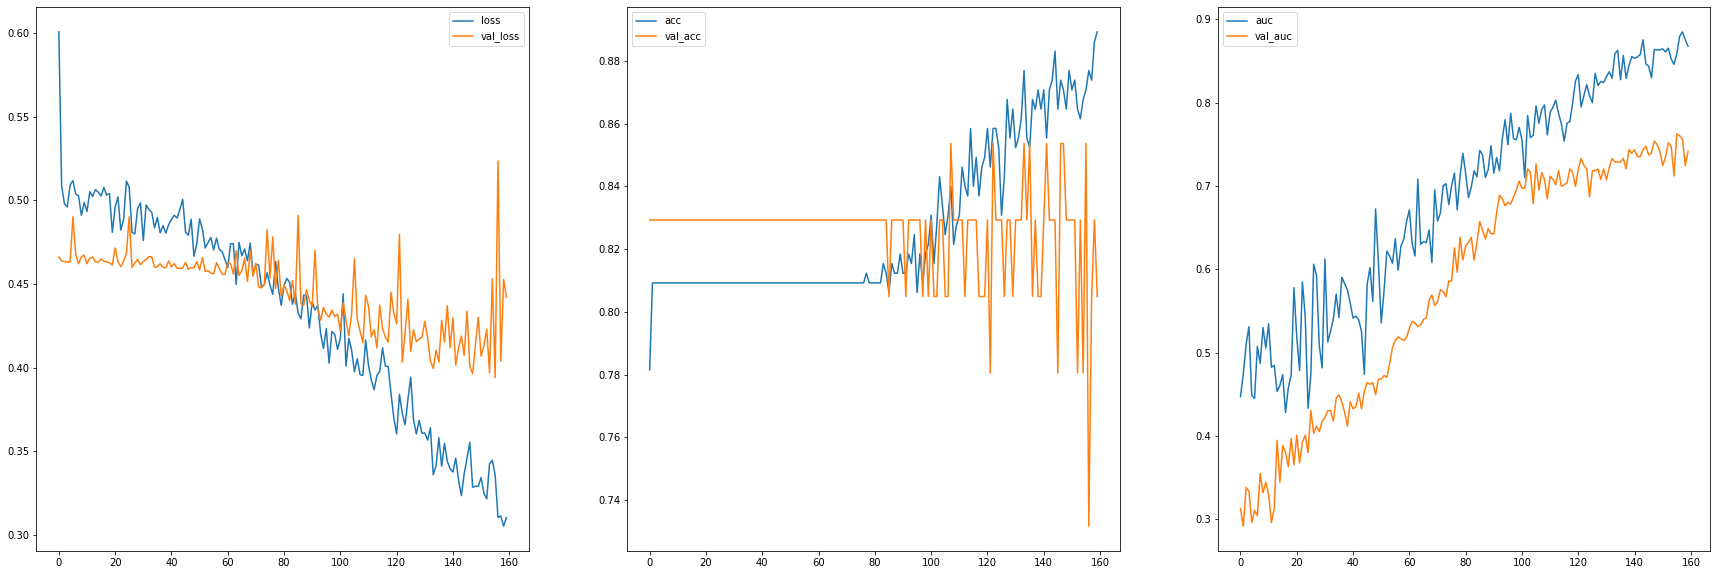

In [27]:
if train:
    plt.figure(figsize = (30,10))
    plt.subplot(1,3,1)
    plt.plot(hist.history['loss'], label = "loss")
    plt.plot(hist.history['val_loss'],label = "val_loss")
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(hist.history['acc'], label = "acc")
    plt.plot(hist.history['val_acc'],label = "val_acc")
    plt.legend()
    plt.subplot(1,3,3)
    plt.plot(hist.history['auc'], label = "auc")
    plt.plot(hist.history['val_auc'],label = "val_auc")
    plt.legend()
    plt.show()

In [28]:
if train:
    epoch_index = 55
    print(hist.history["val_loss"][epoch_index])
    print(hist.history["val_acc"][epoch_index])
    print(hist.history["val_auc"][epoch_index])

0.4561178684234619
0.8292682766914368
0.5147058963775635


## model evaluation

In [29]:
if not train:
    model_3d.load_weights("weights/" + model_name)
if train:
    model_3d.load_weights("weights/epochs/" + model_name)
model_3d.evaluate(x=X_test, y=y_test)

2/2 [==============================] - 11s 5s/step - loss: 0.3361 - acc: 0.8537 - auc: 0.8238


[0.3360665738582611, 0.8536585569381714, 0.8238095045089722]

In [30]:
!pip install statsmodels

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [31]:
y_pred = model_3d.predict(X_test)
# y_pred

array([[0.03320887],
       [0.05495019],
       [0.1778673 ],
       [0.3001959 ],
       [0.02340637],
       [0.43592846],
       [0.14092688],
       [0.11299958],
       [0.07523044],
       [0.17274073],
       [0.05663959],
       [0.27664942],
       [0.2168056 ],
       [0.08083931],
       [0.359178  ],
       [0.38464743],
       [0.02006206],
       [0.395096  ],
       [0.09560981],
       [0.01360441],
       [0.4599971 ],
       [0.09731255],
       [0.02438317],
       [0.04241751],
       [0.10103001],
       [0.24047752],
       [0.31445852],
       [0.08683045],
       [0.1332494 ],
       [0.07267229],
       [0.19382858],
       [0.1174824 ],
       [0.3666798 ],
       [0.02628547],
       [0.17818454],
       [0.27318525],
       [0.20728278],
       [0.30318674],
       [0.06346549],
       [0.02578332],
       [0.09611272]], dtype=float32)

In [32]:
# y_pred = hlp.sigmoid(y_pred)
# y_pred

In [33]:
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

def bin_class_report(X_test,y_test, model):
    """
    modified classification report for binary output
    """
    NLL, Acc, AUC0 = model.evaluate( x=X_test, y=y_test, verbose=0)
    y_pred = model.predict(X_test)
    # cm , AUC
    cm = confusion_matrix(np.round(y_test), np.round(y_pred))
    AUC =  metrics.roc_auc_score(np.round(y_test), np.round(y_pred))
    #acc
    nobs = sum(sum(cm))
    count = sum([cm[0,0], cm[1,1]])
    Acc = count/nobs
    acc_ci_low, acc_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    #sens 
    sens = cm[1,1]/(cm[1,1]+cm[1,0])
    nobs = sum([cm[1,0],cm[1,1]])
    count = sum([cm[1,1]])
    sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    #spec 
    spec = cm[0,0]/(cm[0,1]+cm[0,0])
    nobs = sum([cm[0,1],cm[0,0]])
    count = sum([cm[0,0]])
    spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
    
    print("\nPerformance on Test Set : ")
    print("\nAccuracy    [95% Conf.] :", np.around(Acc,4),np.around([acc_ci_low, acc_ci_upp],4))
    print("Sensitivity [95% Conf.] :", np.around(sens,4), np.around([sens_ci_low, sens_ci_upp],4))
    print("Specificity [95% Conf.] :", np.around(spec,4), np.around([spec_ci_low, spec_ci_upp],4))
    print("\nArea under Curve (AUC) Binary :", np.around(AUC,4))
    print("Area under Curve (AUC) Probability :", np.around(AUC0,4))
    print("Negative Log-Likelihood :", np.around(NLL, 4))
#     print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis =1)))


# model_3d.load_weights("weights/" + model_name)
bin_class_report(X_test, 
                 y_test, 
                 model = model_3d)


Performance on Test Set : 

Accuracy    [95% Conf.] : 0.8537 [0.7156 0.9312]
Sensitivity [95% Conf.] : 0.0 [0.     0.3903]
Specificity [95% Conf.] : 1.0 [0.9011 1.    ]

Area under Curve (AUC) Binary : 0.5
Area under Curve (AUC) Probability : 0.8238
Negative Log-Likelihood : 0.3361


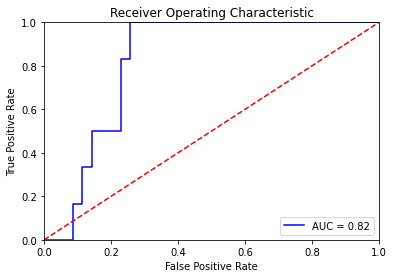

In [34]:
y_pred = model_3d.predict(X_test)

fpr, tpr, threshold = metrics.roc_curve(y_test, (y_pred))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [1]:
threshold

NameError: name 'threshold' is not defined

## Calibration Plots

In [36]:
y_pred = model_3d.predict(X_test)
y_pred = y_pred.squeeze()
print(np.min(y_pred), np.max(y_pred))

0.013604413 0.4599971


In [37]:
cuts = np.quantile(y_pred, q = [0.25, 0.5, 0.75])
cuts = np.insert(cuts, obj = 0, values = 0)
cuts = np.append(cuts, 1)

In [38]:
cuts

array([0.        , 0.06346549, 0.1174824 , 0.27318525, 1.        ])

In [39]:
cut_idx = []
for i in range(len(cuts) - 1):
       cut_idx.append(np.where((y_pred >= cuts[i]) & (y_pred < cuts[i+1]))[0]) 

In [40]:
import random
from statsmodels.stats.proportion import proportion_confint

pred_prob = []
obs_prop = []
obs_prop_up = []
obs_prop_lo = []

for idx in cut_idx:
    pred_prob.append(np.mean(y_pred[idx]))
    obs_prop.append(np.mean(y_test[idx]))
    confint = proportion_confint(count = np.sum(y_test[idx]), 
                                 nobs = len(y_test[idx]), 
                                 alpha = 0.05, 
                                 method = "wilson")
    obs_prop_lo.append(confint[0])
    obs_prop_up.append(confint[1])
    
    
#     bootstraps = []
#     for i in range(1000):
#         bootstraps.append(np.mean(np.random.choice(y_test[idx].tolist(), len(y_test[idx]))))
        
#     obs_prop_up.append(np.quantile(bootstraps, 0.975))
#     obs_prop_lo.append(np.quantile(bootstraps, 0.025))

In [41]:
cal_plot_data = pd.DataFrame(
    {"predicted_probability_mean": pred_prob,
     "predicted_probability_middle": np.convolve(cuts,[.5,.5],"valid"),
     "observed_proportion": obs_prop,
     "observed_proportion_lower": obs_prop_lo,
     "observed_proportion_upper": obs_prop_up
    }
)
cal_plot_data

,predicted_probability_mean,predicted_probability_middle,observed_proportion,observed_proportion_lower,observed_proportion_upper
0,0.032074,0.031733,0.000000,0.000000,0.277533
1,0.088210,0.090474,0.000000,0.000000,0.277533
2,0.177885,0.195334,0.300000,0.107791,0.603222
3,0.351746,0.636593,0.272727,0.097461,0.565645


In [42]:
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# fig, ax = plt.subplots(1,1)

def cal_plot(dat, x_vals, y_vals, lwr_vals, upr_vals, alpha = 1, show = True, col = "C0"):
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    sns.lineplot(
        data=dat, x=x_vals, y=y_vals, 
        marker="o",
        alpha = alpha,
        color = col
    )

    plt.plot([0, 1], [0, 1], c = "grey", linewidth = 2)
    for i in range(dat.shape[0]):
        plt.axvline(dat[x_vals].tolist()[i], 
                    dat[lwr_vals].tolist()[i], 
                    dat[upr_vals].tolist()[i],
                    alpha = alpha,
                    color = col)
    if show:
        plt.show()

# plt.xlim(0, 1)
# plt.ylim(0, 1)

# sns.lineplot(
#     data=cal_plot_data, x="predicted_probability_middle", y="observed_proportion", 
#     marker="o"
# )

# plt.plot([0, 1], [0, 1], c = "grey", linewidth = 2)
# for i in range(cal_plot_data.shape[0]):
#     plt.axvline(cal_plot_data["predicted_probability_middle"].tolist()[i], 
#                 cal_plot_data["observed_proportion_lower"].tolist()[i], 
#                 cal_plot_data["observed_proportion_upper"].tolist()[i])

# plt.show()

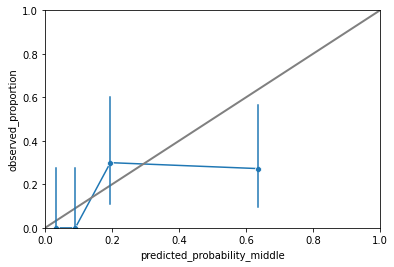

In [44]:
cal_plot(cal_plot_data, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

In [45]:
np.mean(y_test)

0.14634146341463414

In [46]:
andrea_results_ens1 = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens1.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens2 = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens2.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens3 = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens3.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens4 = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens4.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})
andrea_results_ens5 = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/stroke_cimrsbinary_lossnll_wsno_augyes_cdftest_spl6_ens5.csv'
                            ).rename(columns={"Unnamed: 0": "p_idx"})

In [47]:
results = pd.DataFrame(
    {"p_idx": test_idx+1,
     "p_id": p_id[test_idx],
     "mrs": Y_mrs[test_idx],
     "unfavorable": y_test,
     "pred_prob": y_pred, 
     "andrea_pred_prob_ens1": 1-andrea_results_ens1["V2"],
     "andrea_pred_prob_ens2": 1-andrea_results_ens2["V2"],
     "andrea_pred_prob_ens3": 1-andrea_results_ens2["V2"],
     "andrea_pred_prob_ens4": 1-andrea_results_ens2["V2"],
     "andrea_pred_prob_ens5": 1-andrea_results_ens2["V2"]
    }
)
results.head()

,p_idx,p_id,mrs,unfavorable,pred_prob,andrea_pred_prob_ens1,andrea_pred_prob_ens2,andrea_pred_prob_ens3,andrea_pred_prob_ens4,andrea_pred_prob_ens5
0,372,516.0,1.0,0,0.033209,0.016478,0.014460,0.014460,0.014460,0.014460
1,284,376.0,2.0,0,0.054950,0.042760,0.025574,0.025574,0.025574,0.025574
2,298,390.0,2.0,0,0.177867,0.059779,0.066379,0.066379,0.066379,0.066379
3,203,286.0,0.0,0,0.300196,0.254392,0.112507,0.112507,0.112507,0.112507
4,292,384.0,0.0,0,0.023406,0.003612,0.003291,0.003291,0.003291,0.003291


<AxesSubplot:xlabel='unfavorable', ylabel='pred_prob'>

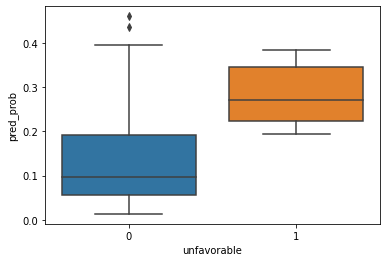

In [48]:
sns.boxplot(data=results, x="unfavorable", y="pred_prob")

### Compare Results

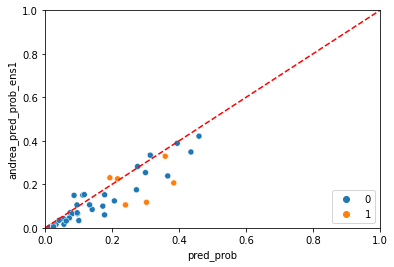

In [49]:
g = sns.scatterplot(data=results, x="pred_prob", y="andrea_pred_prob_ens1", hue = "unfavorable")
plt.legend(loc='lower right')
g.set(ylim=(0, 1), xlim=(0,1))
g.plot([0,1], [0,1], "r--")

In [50]:
andrea_calplot_dat = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/bincal_avgnll.csv')
andrea_calplot_cibinary_avg = andrea_calplot_dat[(andrea_calplot_dat["mod"] == "cimrsbinary") &
                                                 (andrea_calplot_dat["method"] == "trafo") &
                                                 (andrea_calplot_dat["weights"] == "equal")]
andrea_calplot_cibinary_avg
# cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr")

,Unnamed: 0,bin,prop,lwr,upr,cases,midpoint,method,mod,weights
108,109,NaN,0.030303,0.000766,0.327536,0.333333,0.024017,trafo,cimrsbinary,equal
109,110,NaN,0.083333,0.005466,0.418023,0.833333,0.062701,trafo,cimrsbinary,equal
110,111,NaN,0.250000,0.053544,0.598091,2.500000,0.109624,trafo,cimrsbinary,equal
111,112,NaN,0.266667,0.058252,0.616015,2.666667,0.570940,trafo,cimrsbinary,equal


In [51]:
andrea_calplot_dat_spl = pd.read_csv('/tf/notebooks/brdd/xAI_3d/data/bincal_splnll.csv')
andrea_calplot_cibinary_spl = andrea_calplot_dat_spl[(andrea_calplot_dat_spl["mod"] == "cimrsbinary") &
                                                     (andrea_calplot_dat_spl["method"] == "trafo") &
                                                     (andrea_calplot_dat_spl["weights"] == "equal")]
andrea_calplot_cibinary_spl.head()

,Unnamed: 0,bin,prop,lwr,upr,cases,midpoint,spl,method,mod,weights
192,193,"[0,0.00786]",0.0,0.000000,0.284914,0.0,0.003932,1,trafo,cimrsbinary,equal
193,194,"(0.00786,0.0395]",0.1,0.002529,0.445016,1.0,0.023686,1,trafo,cimrsbinary,equal
194,195,"(0.0395,0.0872]",0.1,0.002529,0.445016,1.0,0.063358,1,trafo,cimrsbinary,equal
195,196,"(0.0872,1]",0.2,0.025211,0.556095,2.0,0.543603,1,trafo,cimrsbinary,equal
196,197,"[0,0.0861]",0.0,0.000000,0.284914,0.0,0.043045,2,trafo,cimrsbinary,equal


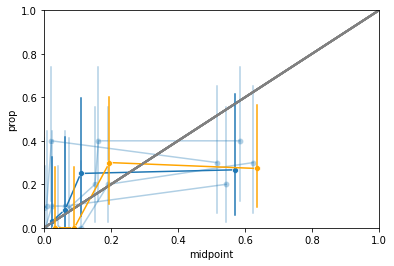

In [52]:
# plt.figure(figsize=(4, 4))

for i in range(5):
    cal_plot(andrea_calplot_cibinary_spl[andrea_calplot_cibinary_spl["spl"] == i], 
             "midpoint", "prop", "lwr", "upr", alpha = .35, show = False)
cal_plot(andrea_calplot_cibinary_avg, "midpoint", "prop", "lwr", "upr", show = False)
cal_plot(cal_plot_data, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", col = "orange")